## Host Stable Diffusion Model on SageMaker MME BYOC Approach

This notebook will locally build a custom docker image and host triton server for testing. It is recommended to run this example outside of SageMaker Studio
<img src="statics/std_diff_mme.jpg"  width="600" height="300">

In [1]:
!pip install -Uq nvidia-pyindex 
!pip install -Uq tritonclient[http]
!pip install -Uq sagemaker ipywidgets pillow numpy transformers accelerate diffusers

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

import tritonclient.http as httpclient
from tritonclient.utils import *
import time
from PIL import Image
import numpy as np

# variables
s3_client = boto3.client("s3")
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# sagemaker variables
role = get_execution_role()
sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
region = sagemaker_session.boto_region_name
account = sagemaker_session.account_id()
bucket = sagemaker_session.default_bucket()

prefix = "mme-statble-diffusion"

### Import and Save Stable Diffusion Model

In [3]:
import diffusers
import torch 

pipeline = diffusers.StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
                                                             cache_dir='hf_cache',
                                                             torch_dtype=torch.float16,
                                                             revision="fp16")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
sd_dir = 'stable_diff'
pipeline.save_pretrained(sd_dir)

In [5]:
import os
import tarfile

sd_tar = f"docker/{sd_dir}.tar.gz"

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

make_tarfile(sd_tar, sd_dir)

### Pack Conda Environment

In [6]:
!cd docker && bash conda_dependencies.sh

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/stablediff_env

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge None
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu None
  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4 None
  ca-certificates    conda-forge/linux-64::ca-certificates-2022.12.7-ha878542_0 None
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.40-h41732ed_0 None
  libffi             conda-forge/linux-64::libffi-3.4.2-h7f98852_5 None
  libgcc-ng          conda-forge/linux-64::libgcc-ng-12.2.0-h65d4601_19 None
  libgomp            conda-forge/linux-64::libgomp-12.2.0-h65d4601_19 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 292.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.9/195.9 kB 375.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 320.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 372.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.3/716.3 kB 17.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 155.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 105.4 MB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.0 MB/s eta 0:00:

### Extend SageMaker Managed Triton Container

In [7]:
# account mapping for SageMaker Triton Image
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}



region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.12-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)
mme_triton_image_uri

'301217895009.dkr.ecr.us-west-2.amazonaws.com/sagemaker-tritonserver:22.12-py3'

In [8]:
!cat docker/Dockerfile

ARG BASE_IMAGE

FROM $BASE_IMAGE

#Install any additional libraries
RUN echo "Adding conda package to Docker image"
RUN mkdir -p /home/condpackenv/

# Copy conda env
COPY stablediff_env.tar.gz /home/condpackenv/stablediff_env.tar.gz

COPY stable_diff.tar.gz /temp/

# Install tar
RUN apt-get update && apt-get install -y tar

# Untar the file
RUN tar -xzf /temp/stable_diff.tar.gz -C /home/

RUN rm /temp/stable_diff.tar.gz

In [9]:
# Change this var to change the name of new container image
new_image_name = 'sagemaker-tritonserver-stable-diffusion-base'

In [10]:
%%capture build_output
!cd docker && bash build_and_push.sh "$new_image_name" "latest" "$mme_triton_image_uri" "$region" "$account"

In [11]:
if 'Error response from daemon' in str(build_output):
    print(build_output)
    raise SystemExit('\n\n!!There was an error with the container build!!')
else:
    extended_triton_image_uri = str(build_output).strip().split('\n')[-1]

In [12]:
extended_triton_image_uri

'376678947624.dkr.ecr.us-west-2.amazonaws.com/sagemaker-tritonserver-stable-diffusion-base:latest'

### Run Triton Server Locally to Test

In [13]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [14]:
model_dir = "model_repo"

In [15]:
!docker run --gpus=all -d --shm-size=4G --rm -p8000:8000 -p8001:8001 -p8002:8002 -v$(pwd)/$model_dir:/model_repository $extended_triton_image_uri tritonserver --model-repository=/model_repository --exit-on-error=false
time.sleep(90)

64b836bf41eb1d7f58d6ea4908dafde00cccd7522918a94b4c4a98446a5ab8e7


In [16]:
CONTAINER_ID=!docker container ls -q
FIRST_CONTAINER_ID = CONTAINER_ID[0]

In [17]:
!echo $FIRST_CONTAINER_ID

64b836bf41eb


In [18]:
!docker logs $FIRST_CONTAINER_ID


== Triton Inference Server ==

NVIDIA Release 22.12 (build <unknown>)
Triton Server Version 2.29.0

Copyright (c) 2018-2022, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

NOTE: CUDA Forward Compatibility mode ENABLED.
  Using CUDA 11.8 driver version 520.61.05 with kernel driver version 515.65.01.
  See https://docs.nvidia.com/deploy/cuda-compatibility/ for details.

I0312 15:25:04.763172 1 pinned_memory_manager.cc:240] Pinned memory pool is created at '0x7fa290000000' with size 268435456
I0312 15:25:04.764441 1 cuda_memory_manager.cc:105] CUDA memory pool is created on device 0 with size 67108864
I0312 15:25:04.771078 1 mode

took 9.476743936538696 seconds


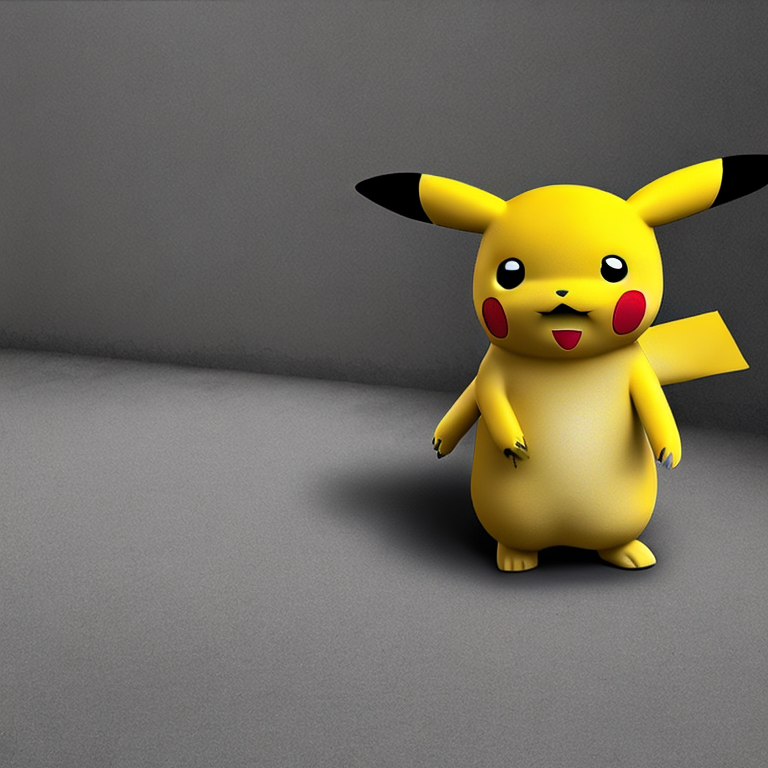

In [20]:
client = httpclient.InferenceServerClient(url="localhost:8000")

prompt = "Pikachu in a detective trench coat, photorealistic, nikon"
text_obj = np.array([prompt], dtype="object").reshape((-1, 1))

input_text = httpclient.InferInput("prompt", text_obj.shape, np_to_triton_dtype(text_obj.dtype))

input_text.set_data_from_numpy(text_obj)

output_img = httpclient.InferRequestedOutput("generated_image")

start = time.time()
query_response = client.infer(model_name="pipeline_1", inputs=[input_text], outputs=[output_img])
print(f"took {time.time()-start} seconds")

image = query_response.as_numpy("generated_image")
im = Image.fromarray(np.squeeze(image))
im.save("generated_image.jpg")

display(im)

In [21]:
!docker kill $FIRST_CONTAINER_ID

64b836bf41eb


## Deploy SD to MME

In [22]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [23]:
!find . | grep -E "(__pycache__|\.pyc$)" | xargs sudo rm -rf

In [24]:
sd_pipelines = ["pipeline_0", "pipeline_1"]

model_targets = []
for sd in sd_pipelines:
    
    tar_name = f"sd_{sd}.tar.gz"
    model_targets.append(tar_name)

    !tar -C $model_dir -zcvf $tar_name $sd
    
    sagemaker_session.upload_data(path=tar_name, key_prefix=f"{prefix}/byoc-models")

    
print(model_targets)

pipeline_0/
pipeline_0/config.pbtxt
pipeline_0/1/
pipeline_0/1/model.py
pipeline_1/
pipeline_1/config.pbtxt
pipeline_1/1/
pipeline_1/1/model.py
['sd_pipeline_0.tar.gz', 'sd_pipeline_1.tar.gz']


In [25]:
model_data_url = f"s3://{bucket}/{prefix}/byoc-models/"
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": extended_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
}

In [26]:
sm_model_name = f"{prefix}-mdl-{ts}"

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-west-2:376678947624:model/mme-statble-diffusion-mdl-2023-03-12-15-47-46


Create a SageMaker endpoint configuration.

In [27]:
endpoint_config_name = f"{prefix}-epc-{ts}"
instance_type = 'ml.g5.xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint-config/mme-statble-diffusion-epc-2023-03-12-15-47-46


In [28]:
endpoint_name = f"{prefix}-ep-{ts}"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint/mme-statble-diffusion-ep-2023-03-12-15-47-46
Status: InService


## Invoke models

In [30]:
prompt = "fire bird and ice lion"
inputs = []
outputs = []

text_obj = np.array([prompt], dtype="object").reshape((-1, 1))

inputs.append(httpclient.InferInput("prompt", text_obj.shape, np_to_triton_dtype(text_obj.dtype)))
inputs[0].set_data_from_numpy(text_obj)


outputs.append(httpclient.InferRequestedOutput("generated_image"))

Since we are using the SageMaker Runtime client to send an HTTP request to the endpoint now, we use Triton's generate_request_body method to create the right request format for us.

In [31]:
request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
    inputs, outputs=outputs
)

print(request_body)

b'{"inputs":[{"name":"prompt","shape":[1,1],"datatype":"BYTES","parameters":{"binary_data_size":26}}],"outputs":[{"name":"generated_image","parameters":{"binary_data":true}}]}\x16\x00\x00\x00fire bird and ice lion'


In [32]:
import random

target_model = random.choice(model_targets)
print(target_model)

pipeline_0


In [33]:
%%time
response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(header_length),
            Body=request_body,
            TargetModel=target_model
        )

CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 36.9 s


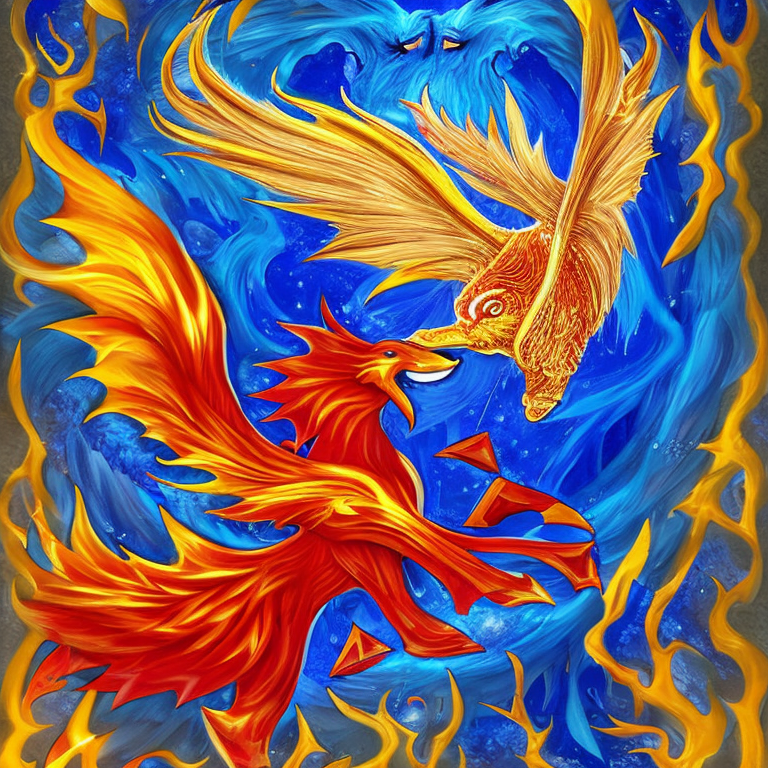

In [34]:
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="

header_length_str = response["ContentType"][len(header_length_prefix) :]
result = httpclient.InferenceServerClient.parse_response_body(
            response["Body"].read(), header_length=int(header_length_str))
image_array = result.as_numpy("generated_image")
image = Image.fromarray(np.squeeze(image_array))

display(image)